[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

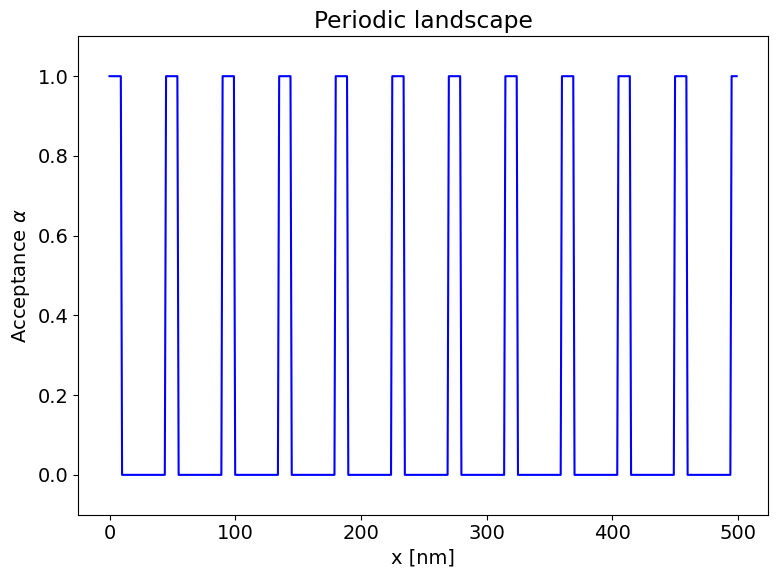

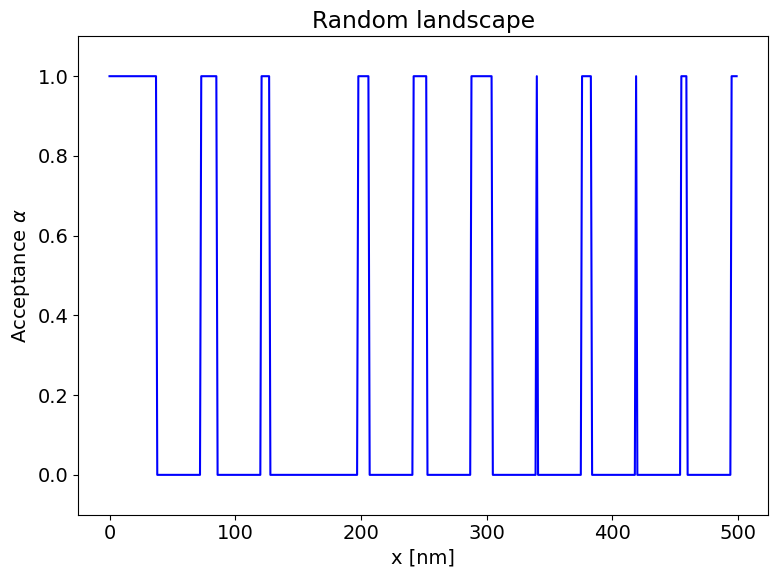

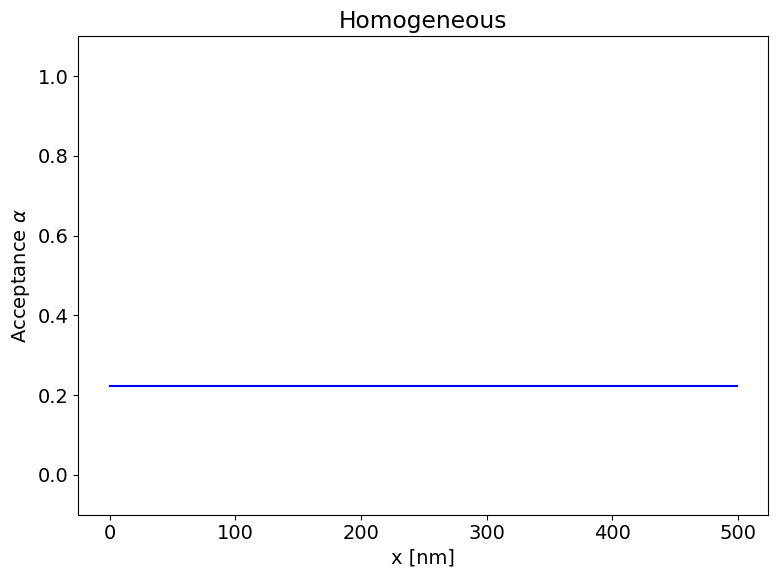

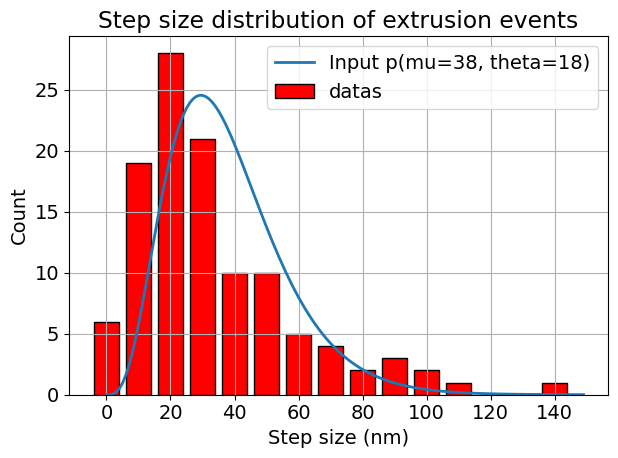

In [32]:
# ─────────────────────────────────────────────
# 1 : FIGURE - Model
# ─────────────────────────────────────────────


# 1.1 : Landscapes

from ncl.landscape import alpha_random, alpha_periodic, alpha_homogeneous
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 14


# Values in nm
s = 35
l = 10
alphao = 0
alphaf = 1
Lmin = 0
Lmax = 500
bps = 1

# Landscapes
obs_1 = alpha_periodic(s=s, l=l, alphao=alphao, alphaf=alphaf, Lmin=0, Lmax=Lmax, bps=bps)
obs_2 = alpha_random(s=s, l=l, alphao=alphao, alphaf=alphaf, Lmin=0, Lmax=Lmax, bps=bps)
obs_3 = alpha_homogeneous(s=s, l=l, alphao=alphao, alphaf=alphaf, Lmin=0, Lmax=Lmax, bps=bps)
x = np.arange(0,len(obs_1),1)

print(obs_1)

plt.figure(figsize=(8,6))
plt.plot(x, obs_1, c="b")
plt.title("Periodic landscape")
plt.xlabel("x [nm]")
plt.ylabel(r"Acceptance $\alpha$")
plt.ylim([-0.1, 1.1])
# plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, obs_2, c="b")
plt.title("Random landscape")
plt.xlabel("x [nm]")
plt.ylabel(r"Acceptance $\alpha$")
plt.ylim([-0.1, 1.1])
# plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, obs_3, c="b")
plt.title("Homogeneous")
plt.xlabel("x [nm]")
plt.ylabel(r"Acceptance $\alpha$")
plt.ylim([-0.1, 1.1])
# plt.grid(True)
plt.tight_layout()
plt.show()


# 1.2 : Probabilities

import matplotlib.pyplot as plt
import numpy as np
from tls.probabilities import proba_gamma
plt.rcParams["font.size"] = 14

x = np.arange(0,150,10)
x_fine = np.arange(0,150,1)
# y = np.array([10, 140, 240, 200, 130, 125, 90, 60, 30, 25, 20, 10, 15, 7, 5])
y = np.array([1, 0, 0, 1, 2, 3, 2, 4, 5, 10, 10, 21, 28, 19, 6])
y_invert = y[::-1]

mu = 38
theta = 18

p = proba_gamma(mu=mu, theta=theta, L=x_fine) * 1_000

plt.figure()
plt.grid(True)
plt.bar(x, y_invert, color="r", width=8, edgecolor="black", label="datas")
plt.plot(x_fine, p, lw=2, label=f'Input p(mu={mu}, theta={theta})')
plt.xlabel("Step size (nm)")
plt.ylabel("Count")
plt.title("Step size distribution of extrusion events")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ─────────────────────────────────────────────
# 2 : FIGURE - Heatmaps
# ─────────────────────────────────────────────

In [1]:
# ─────────────────────────────────────────────
# 3 : FIGURE - Density
# ─────────────────────────────────────────────


# 3.1 : Librairies
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path


# 3.2 : Datas

# DataFrame : RANDOM
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-11-04__PC/nucleo__access_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_random = (
    pl.scan_parquet(paths)
    .filter(pl.col("landscape") == "random")
    .collect()
    .sort(by=["landscape", "bpmin", "l"],
          descending=[False, False, False]
        )
)

# DataFrame : PERIODIC
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-11-13__PC/nucleo__accessperiodic_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_periodic = (
    pl.scan_parquet(paths)
    .filter((pl.col("landscape") == "periodic") & (pl.col("nt") == 10_000))
    .collect()
    .sort(by=["landscape", "l", "parameter"],
          descending=[False, False, False]
        )
)

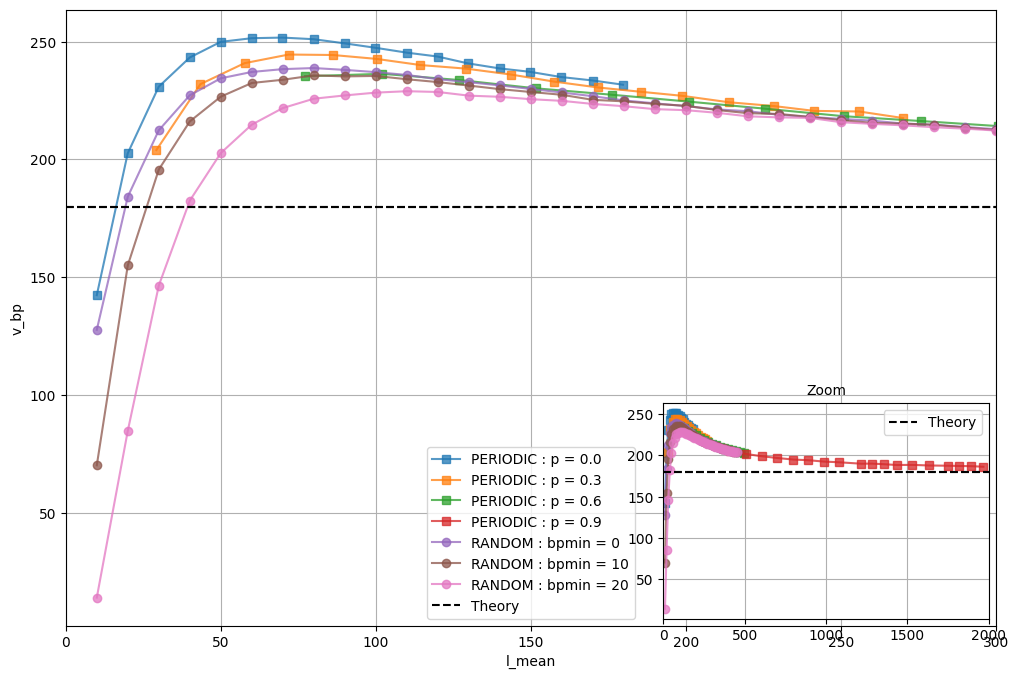

In [3]:
# 3.3 : Plot


# --- Initialization --- #

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.figure(figsize=(12,8))

# Xlmis for plot and inset
xlim_main   = 300
xlim_sub    = 2_000


# --- Periodic --- #

# Periodic : Values to keep
# params_to_keep = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
params_to_keep = [0.0, 0.3, 0.6, 0.9]
df_periodic = df_periodic.with_columns(
    pl.col("parameter").round(3).alias("parameter")
)
df_periodic_filtered = df_periodic.filter(
    pl.col("parameter").is_in(params_to_keep)
)

# Periodic : Colors
random_cmap = plt.cm.viridis
p = df_periodic_filtered["parameter"].to_numpy()
p_values = np.unique(p)
random_norm = plt.Normalize(vmin=min(p_values), vmax=max(p_values))

# Periodic : Loop over configurations
for group in df_periodic_filtered.partition_by("parameter", as_dict=False):
    parameter   = group["parameter"][0]
    l_mean      = group["l_mean"].to_numpy()
    v_site      = group["v_mean"].to_numpy()
    c           = (150 + l_mean) / (35 + l_mean)
    v_bp        = v_site * c
    # color       = random_cmap(random_norm(parameter))    
    plt.plot(l_mean, v_bp, marker="s", ls="-", alpha=0.75, label=f"PERIODIC : p = {parameter}")


# --- Random --- #

# Random : Values to keep
# bpmin_to_keep = [0, 5, 10, 15]
bpmin_to_keep = [0, 10, 20]
df_random = df_random.with_columns(
    pl.col("bpmin").round(3).alias("bpmin")
)
df_random_filtered = df_random.filter(
    pl.col("bpmin").is_in(bpmin_to_keep)
) 

# Random : Colors
random_cmap = plt.cm.plasma
bp = df_random_filtered["bpmin"].to_numpy()
bp_values = np.unique(bp)
random_norm = plt.Normalize(vmin=min(bp_values), vmax=max(bp_values))

# Random : Loop over configurations
for group in df_random_filtered.partition_by("bpmin", as_dict=False):
    bpmin   = group["bpmin"][0]
    l_mean  = group["l"].to_numpy()
    v_site  = group["v_mean"].to_numpy()
    c       = (150 + l_mean) / (35 + l_mean)
    v_bp    = v_site * c
    # color   = random_cmap(random_norm(bpmin))    
    plt.plot(l_mean, v_bp, marker="o", ls="-", alpha=0.75, label=f"RANDOM : bpmin = {bpmin}")


# --- Architecture Plot --- #
plt.axhline(180, c="k", ls="--", label="Theory")
plt.xlim([0, xlim_main])
plt.xlabel("l_mean")
plt.ylabel("v_bp")
plt.grid(True)
plt.axhline(180, c="k", ls="--")
plt.legend(loc="lower center")


# --- Inset --- #

ax = plt.gca()  
ax_inset = inset_axes(ax, width="35%", height="35%", loc="lower right")

# Periodic inset
for group in df_periodic_filtered.partition_by("parameter", as_dict=False):
    parameter   = group["parameter"][0]
    l_mean      = group["l_mean"].to_numpy()
    v_site      = group["v_mean"].to_numpy()
    c           = (150 + l_mean) / (35 + l_mean)
    v_bp        = v_site * c
    # color       = random_cmap(random_norm(parameter))
    ax_inset.plot(l_mean, v_bp, marker="s", ls="-", alpha=0.75)

# Random inset
for group in df_random_filtered.partition_by("bpmin", as_dict=False):
    bpmin   = group["bpmin"][0]
    l_mean  = group["l"].to_numpy()
    v_site  = group["v_mean"].to_numpy()
    c       = (150 + l_mean) / (35 + l_mean)
    v_bp    = v_site * c
    # color   = random_cmap(random_norm(bpmin))
    ax_inset.plot(l_mean, v_bp, marker="o", ls="-", alpha=0.75)

# Inset config
ax_inset.set_xlim([0, xlim_sub])
ax_inset.set_ylim(ax.get_ylim())
ax_inset.grid(True)
ax_inset.set_title("Zoom", fontsize=10)


# --- Architecture Inset --- #
plt.axhline(180, c="k", ls="--", label="Theory")
plt.xlim([0, xlim_sub])
# plt.xlabel("l_mean")
# plt.ylabel("v_bp")
plt.grid(True)
plt.axhline(180, c="k", ls="--")
plt.legend()


# --- Show --- #
plt.show()

# .